# **Sentiment Analysis - Fine Tuning ALBERT for Sentiment Analysis on IMDB Movie Reviews**

**Introduction**
* Large Language Models are nothing but the algorithms specially designed for the task of understanding and generating the human language by predicting the likelihood of word sequences. In Natural Language Processing it helps for tasks like translation, sentiment analysis and text generation. BERT is a specific type of transformer based LLM model which uses the attention mechanism in order to understand the context of words in sequence. It processes text data bidirectionally which means it considers both left and right content. This working mechanism helps it  to capture nuanced  meanings of  words based on surrounding words which makes it highly effective for various NLP tasks like question answering and text classification.

**Objective**
* The main objective of this assignment is to train and fine tune the BERT LMM model for a NLP task. The sentiment analysis is performed  on the IMDB movies reviews dataset.

**Goal :** BERT style model ALBERT is fine tuned here for this task of classifying reviews as positive or negative.

# Installations

In [ ]:
pip install transformers datasets torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


# Libraries

In [ ]:
# importing all the essencial libraries
from collections import Counter
from datasets import load_dataset
import matplotlib.pyplot as plt
from transformers import (
    AlbertTokenizer,
    AlbertForSequenceClassification,
    TFAutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    AutoTokenizer
)
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
import torch
import tensorflow as tf

# Load and Explore Data

In [ ]:
# loading IMDB dataset for sentiment analysis
dataset = load_dataset("imdb")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
# cheching the dataset
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

* IMDb dataset is a data dictionary containing three splits: train, test and unsupervised.

* TIt contains train (25000 labeled reviews for training), test (25000 labeled reviews for evaluation) and unsupervised (50000 unlabeled reviews for pretraining or semi-supervised learning).


In [ ]:
# Checking column names and types
print(dataset["train"].column_names)
print(dataset["train"].features)

['text', 'label']
{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['neg', 'pos'], id=None)}


* It contains two columns: text and label (categorical class with 'neg' for negative and 'pos' for positive sentiment)

In [ ]:
# examining first review and its label from the training daatset
reviews = dataset["train"]["text"][0]
labels = dataset["train"]["label"][0]

In [ ]:
# 1st review
reviews

'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, ev

In [ ]:
# label of 1st review
labels

0

In [ ]:
# checking label distribution in the training dataset
label_counts = Counter(dataset["train"]["label"])
print("Label Distribution:", label_counts)

Label Distribution: Counter({0: 12500, 1: 12500})


* Here we can see that the label distribution in the training set is balanced with 12500 negative and 12500 positive reviews

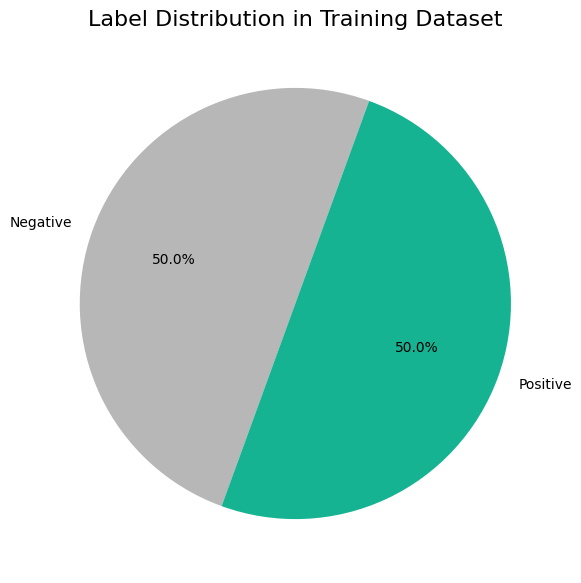

In [ ]:
# visuvalising the label distribution in the training dataset - Pie chart

# Extracting the labels and their total counts
label_counts = Counter(dataset["train"]["label"])
labels = ['Negative', 'Positive']
counts = [label_counts[0], label_counts[1]]

# Plotting the pie chart
plt.figure(figsize=(7, 7))
plt.pie(counts, labels=labels, colors=['#B7B7B7', '#15B392'], autopct='%1.1f%%', startangle=70)
plt.title("Label Distribution in Training Dataset", fontsize=16)
plt.show()

* The above pie chart clearly indicates that the loaded IMDB dataset is completely balanced in nature as equal 50% samples of both classes are present on the dataset.
* This pie chart with 2 distinct colours of slice representing the class distrubution in percentage makes the analysis easier.

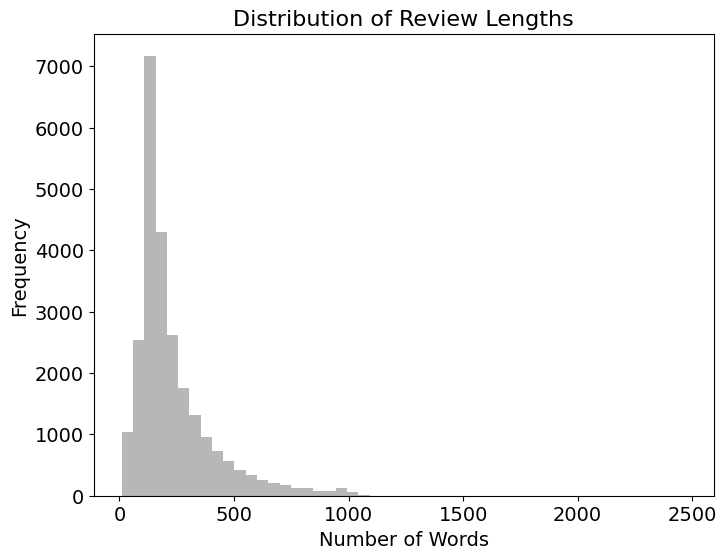

In [ ]:
# Calculate and visuvalising the length of each review from the training dataset - Histogram
plt.figure(figsize=(8, 6))
text_lengths = [len(text.split()) for text in dataset["train"]["text"]]
plt.hist(text_lengths, bins=50, color='#B7B7B7')
plt.title("Distribution of Review Lengths", fontsize=16)
plt.xlabel("Number of Words", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

# font size for tick marks
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()

* The above histogram indicates that the highest frequency of reviews are concentrated in the range of 0-500 words which indicates that large number of users tend to provide concise feedback.

# Tokenisation

Tokenizer converts the text into numerical format (input IDs and attention masks) suitable for the ALBERT model

In [ ]:
# Loading ALBERT tokenizer
tokenizer = AlbertTokenizer.from_pretrained("albert-base-v2")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

In [ ]:
# defining the tokenisation function
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True)

This function applies the tokeniser to convert reviews into tokens with padding and truncation to ensure uniform sequence length.

In [ ]:
# Tokenising the IMDB dataset
tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Spliting the dataset into train and test dataset
train_dataset = tokenized_dataset['train']
test_dataset = tokenized_dataset['test']

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
# first sample from the tokenised dataset
sample = train_dataset[0]
print(sample)

{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

In [ ]:
# Decoding the input_ids back to tokens
tokens = tokenizer.convert_ids_to_tokens(sample['input_ids'])
print(tokens)

['[CLS]', '▁i', '▁rented', '▁i', '▁am', '▁curious', '-', 'yellow', '▁from', '▁my', '▁video', '▁store', '▁because', '▁of', '▁all', '▁the', '▁controversy', '▁that', '▁surrounded', '▁it', '▁when', '▁it', '▁was', '▁first', '▁released', '▁in', '▁1967', '.', '▁i', '▁also', '▁heard', '▁that', '▁at', '▁first', '▁it', '▁was', '▁seized', '▁by', '▁u', '.', 's', '.', '▁customs', '▁if', '▁it', '▁ever', '▁tried', '▁to', '▁enter', '▁this', '▁country', ',', '▁therefore', '▁being', '▁a', '▁fan', '▁of', '▁films', '▁considered', '▁', '"', 'con', 'tro', 'vers', 'ial', '"', '▁i', '▁really', '▁had', '▁to', '▁see', '▁this', '▁for', '▁myself', '.', '<unk>', 'br', '▁', '/', '<unk>', 'br', '▁', '/', '<unk>', 'the', '▁plot', '▁is', '▁centered', '▁around', '▁a', '▁young', '▁swedish', '▁drama', '▁student', '▁named', '▁lena', '▁who', '▁wants', '▁to', '▁learn', '▁everything', '▁she', '▁can', '▁about', '▁life', '.', '▁in', '▁particular', '▁she', '▁wants', '▁to', '▁focus', '▁her', '▁attention', 's', '▁to', '▁making', 

* This shows how the original text is tokenized into subwords and special tokens like [CLS] and [SEP]


# Fine Tuning

In [ ]:
# Loading the ALBERT model for sequence classification
model = AlbertForSequenceClassification.from_pretrained("albert-base-v2", num_labels=2)

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Setting training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy='epoch',
    logging_dir='./logs',
    report_to="none",  # Disable W&B logging
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


**TrainingArgument specifies parameters for training :**
* output_dir: Directory to save training results.
* num_train_epochs: Number of epochs
* per_device_train_batch_size: Training batch size
* per_device_eval_batch_size: Evaluation batch size
* evaluation_strategy='epoch': Evaluate the model at the end of every epoch
* logging_dir: Directory for logging training progress.

In [ ]:
# Initialising the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

**Trainer: Handles training and evaluation with these inputs:**
* model: ALBERT model loaded earlier.
* args: Training arguments.
* train_dataset: Tokenized training dataset.
* eval_dataset: Tokenized test dataset.

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
# Training the model using the specified training arguments
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.417400,0.454654
2,0.361500,0.368386
3,0.264600,0.353057


TrainOutput(global_step=9375, training_loss=0.3789014558919271, metrics={'train_runtime': 10232.8441, 'train_samples_per_second': 7.329, 'train_steps_per_second': 0.916, 'total_flos': 1792357632000000.0, 'train_loss': 0.3789014558919271, 'epoch': 3.0})

In [ ]:
# Evaluating the performance of model
predictions, label_ids, metrics = trainer.predict(test_dataset)

# Converting logits to predicted labels
pred_labels = torch.argmax(torch.tensor(predictions), dim=-1)

In [ ]:
# evaluation results of the model
accuracy = accuracy_score(label_ids, pred_labels)
precision = precision_score(label_ids, pred_labels, average='binary')  #
recall = recall_score(label_ids, pred_labels, average='binary')
f1 = f1_score(label_ids, pred_labels, average='binary')
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9052
Precision: 0.9005
Recall: 0.9110
F1 Score: 0.9058


In [ ]:
# printing the classification report
print(classification_report(label_ids, pred_labels))

              precision    recall  f1-score   support

           0       0.91      0.90      0.90     12500
           1       0.90      0.91      0.91     12500

    accuracy                           0.91     25000
   macro avg       0.91      0.91      0.91     25000
weighted avg       0.91      0.91      0.91     25000



In [ ]:
# Saving trained model and tokenizer
model.save_pretrained("./albert_sentiment_model")
tokenizer.save_pretrained("./albert_sentiment_tokenizer")

('./albert_sentiment_tokenizer/tokenizer_config.json',
 './albert_sentiment_tokenizer/special_tokens_map.json',
 './albert_sentiment_tokenizer/spiece.model',
 './albert_sentiment_tokenizer/added_tokens.json')

# Testing

In [ ]:
# Loading trained ALBERT model and tokenizer
model = AlbertForSequenceClassification.from_pretrained("./albert_sentiment_model")
tokenizer = AlbertTokenizer.from_pretrained("./albert_sentiment_tokenizer")

## Test Case - I

In [ ]:
# Test case 1
test_input_1 = "The movie was thrilling and kept me on the edge of my seat the entire time!"
inputs_1 = tokenizer(test_input_1, return_tensors="pt", padding=True, truncation=True)
model.eval()
with torch.no_grad():
    outputs_1 = model(**inputs_1)
logits_1 = outputs_1.logits
predicted_label_1 = torch.argmax(logits_1, dim=-1).item()
label_map = {0: "Negative", 1: "Positive"}
predicted_sentiment_1 = label_map[predicted_label_1]

print(f"Input: {test_input_1}")
print(f"Predicted Sentiment: {predicted_sentiment_1}")

Input: The movie was thrilling and kept me on the edge of my seat the entire time!
Predicted Sentiment: Positive


## Test Case - II

In [ ]:
# Test case 2
test_input_2 = "An absolute masterpiece! The visuals, music and performances were incredible."
inputs_2 = tokenizer(test_input_2, return_tensors="pt", padding=True, truncation=True)
with torch.no_grad():
    outputs_2 = model(**inputs_2)
logits_2 = outputs_2.logits
predicted_label_2 = torch.argmax(logits_2, dim=-1).item()
predicted_sentiment_2 = label_map[predicted_label_2]

print(f"Input: {test_input_2}")
print(f"Predicted Sentiment: {predicted_sentiment_2}")

Input: An absolute masterpiece! The visuals, music and performances were incredible.
Predicted Sentiment: Positive


## Test Case - III

In [ ]:
# Test case 3
test_input_3 = "The plot was so predictable that I lost interest halfway through."
inputs_3 = tokenizer(test_input_3, return_tensors="pt", padding=True, truncation=True)
with torch.no_grad():
    outputs_3 = model(**inputs_3)
logits_3 = outputs_3.logits
predicted_label_3 = torch.argmax(logits_3, dim=-1).item()
predicted_sentiment_3 = label_map[predicted_label_3]

print(f"Input: {test_input_3}")
print(f"Predicted Sentiment: {predicted_sentiment_3}")

Input: The plot was so predictable that I lost interest halfway through.
Predicted Sentiment: Negative


## Test Case - IV

In [ ]:
# Test case 4
test_input_4 = "The movie had a great cast, but the story was poorly written and dragged on."
inputs_4 = tokenizer(test_input_4, return_tensors="pt", padding=True, truncation=True)
with torch.no_grad():
    outputs_4 = model(**inputs_4)
logits_4 = outputs_4.logits
predicted_label_4 = torch.argmax(logits_4, dim=-1).item()
predicted_sentiment_4 = label_map[predicted_label_4]

print(f"Input: {test_input_4}")
print(f"Predicted Sentiment: {predicted_sentiment_4}")

Input: The movie had a great cast, but the story was poorly written and dragged on.
Predicted Sentiment: Negative


# Final Conclusion

The "albert-base-v2" model has showed the strong performance in sentiment analysis by effectively distinguishing between positive and negative sentiments in movie reviews. It accurately identified positive as well as negative sentiments in reviews. This showcases the model's ability to correctly interpret emotional tones which makes it a reliable for sentiment analysis in text based applications such as movie reviews.